<a href="https://colab.research.google.com/github/alirezahekmati/Image-to-lab/blob/main/Opentron_Image_to_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Run this block once per runtime to set up your environment
####
#### Set up the runtime environment -- install and import needed packages
####

!pip install opentrons

from opentrons import types

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)


# Petri dish size constants
PETRI_INNER_DIAMETER = 84   # 84mm is hopefully a tight lower bound on inner diameter of "90mm" & "100mm" petri dishes
MAX_DRAW_RADIUS = PETRI_INNER_DIAMETER/2 - 2   # leave 2mm margin for the tip size, drop size, miscalibration, etc.


####
#### Define some classes for our custom HTGAA Opentrons simulator/visualizer
####

nullLocation = types.Location(types.Point(x=250, y=250, z=250), None)

def same2DLocation(loc1, loc2):     # ignores z (=> tests x, y, and labware)
    return loc1.point.x == loc2.point.x and loc1.point.y == loc2.point.y and loc1.labware == loc2.labware

def mock_print(str):
    #print("...\n" + str)
    pass

# each PipetteSim instance tracks what it's dispensed; if you have multiple, need to call visualize() on each.
# (can't unify multiple by making the instance variables into class variables; note this colab has at least
#  one instance per example, and we don't want those sharing dispense states.)
class PipetteSim:   # modeled after InstrumentContext in the opentrons api
  def __init__(self, instrument_official_name, mount_LR, tip_rack_list, well_colors):
    if instrument_official_name != "p20_single_gen2":
      raise ValueError(f"Unsupported pipette {instrument_official_name} -- should be p20_single_gen2")
    self.max_volume = 20
    self.instrument_official_name = instrument_official_name

    if mount_LR != "right":
      raise ValueError(f"Unsupported pipette mount {mount_LR} -- should be right")
    self.mount_LR = mount_LR

    if tip_rack_list[0].labware_official_name != "opentrons_96_tiprack_20ul":
      raise ValueError(f"Unsupported tip rack {tip_rack_list[0].labware_official_name} -- should be opentrons_96_tiprack_20ul")
    self.tip_rack_list = tip_rack_list

    self.well_colors = well_colors
    self.droplets_x = []
    self.droplets_y = []
    self.droplets_size = []
    self.droplets_color = []
    self.smears = []                # list of 3-tuples: (xlist, ylist, color)
    self.location = nullLocation    # used by dispense_and_jog()
    self.justDispensedAt = None
    self.current_volume = 0
    self.aspirated_loc = None
    self.totalAspirated = {}        # 'color' : total
    self.totalDispensed = {}        # 'color' : total
    self.curr_color = 'orange'
    self.has_tip = False            # (in the opentrons api!)
    self.tip_count = 0

  def __del__(self):
    if self.has_tip:
      raise Exception("### ERROR: Run completed without dropping the tip!") # python prints but ignores exceptions in destructors

  # used by our dispense_and_jog() routine
  def _get_last_location_by_api_version(self):  # (in the opentrons api!)
    return self.location

  # use the well id to make up a location on the petri dish diagram:
  # D6 in the center, A1 lower left, H12 upper right (assuming 96-well, but will work for any)
  def petriLocOfWell(self, well):   # (NOT in opentrons api)
    assert(isinstance(well, WellMock))
    x,y = well.get_row_col()
    return well.top().move(types.Point(x=(x-ord('D')) * MAX_DRAW_RADIUS/4,
                                       y=(y-6) * MAX_DRAW_RADIUS/6,
                                       z=0))

  # but no smear if it's just a z-move
  def smearIfJustDispensed(self, loc):  # (NOT in opentrons api)
    assert(isinstance(loc, (types.Location, WellMock)))
    if self.justDispensedAt is not None:
      newloc = loc if isinstance(loc, types.Location) else self.petriLocOfWell(loc)
      if not same2DLocation(self.justDispensedAt, newloc):
        line_end = self.justDispensedAt.move(0.5 * (newloc.point - self.justDispensedAt.point))
        self.smears.append(([self.justDispensedAt.point.x, line_end.point.x],
                            [self.justDispensedAt.point.y, line_end.point.y],
                            self.curr_color))
    self.justDispensedAt = None

  def dispense(self, volume, location): # (in opentrons api)
    assert(isinstance(location, types.Location)) # not allowing dispensing into well or trashbin/wastechute for this lab -- petri only!
    assert(isinstance(volume, (int, float)))
    if (location.point.x**2 + location.point.y**2 > MAX_DRAW_RADIUS**2):
      raise ValueError(f'Dispensing outside "safe" area: Point ({location.point.x}, {location.point.y}) is more than' +
                       f" {MAX_DRAW_RADIUS}mm away from the petri dish's center.")
    if not self.has_tip:
      raise RuntimeError("dispense() called when no tip was being held")
    if self.current_volume < volume:
      raise ValueError(f"You dispensed {volume}uL, which is more than was in the pipette ({self.current_volume}uL).")
    if volume <= 0:
      raise ValueError(f"Dispensing {volume}uL -- you should dispense a positive amount.")
    if location.point.z < 0:
      raise ValueError(f"dispense() passed a location with z={location.point.z} -- do not go below z=0!")
    if location.point.z >= 10:
      print(f"Dispensing from a location with z={location.point.z} -- do you really want to dispense from that high?")
    self.smearIfJustDispensed(location)
    self.current_volume -= volume
    self.droplets_x.append(location.point.x)
    self.droplets_y.append(location.point.y)
    self.droplets_size.append(volume * 100)     # unprincipled scale factor (1uL->100 sq.pt), but it works
    self.droplets_color.append('lime' if self.curr_color.lower()=='green' else self.curr_color) # map green -> lime (looks more like GFP)
    self.totalDispensed.setdefault(self.curr_color, 0)
    self.totalDispensed[self.curr_color] += volume
    self.location = location
    self.justDispensedAt = location

  def aspirate(self, volume, location):     # (in opentrons api)
    assert(isinstance(volume, (int, float)))
    assert(isinstance(location, (types.Location, WellMock)))
    if not self.has_tip:
      raise RuntimeError("aspirate() called when no tip was being held")
    if volume + self.current_volume > self.max_volume:
      raise ValueError(f"Aspirating {volume}uL + {self.current_volume}uL already in pipette = {volume + self.current_volume}uL,"
                       f" which is more than the pipette can hold ({self.max_volume}uL).")
    if volume <= 0:
      raise ValueError(f"Aspirating {volume}uL -- you should aspirate a positive amount.")
    if self.aspirated_loc is not None and self.aspirated_loc != location:
      raise RuntimeError(f"Cross-contaminating wells {self.aspirated_loc} and {location} with a single pipette")
    self.aspirated_loc = location
    self.smearIfJustDispensed(location)
    self.current_volume += volume
    if isinstance(location, WellMock):
      if location.well_id.upper() not in (id.upper() for id in self.well_colors.keys()):
        raise ValueError(f"aspirate() was passed well location {location} which hasn't been configured to have a color.")
      color = location.color()
      newloc = location
    else:   # legal for aspirate() but we should probably treat this as an error for this lab?  right now marking it white...
      print(f"WARNING -- aspirate() passed a Location rather than a well -- are you sure you know what you're doing?")
      if location.point.z < 0:
        raise ValueError(f"aspirate() passed a location with z={location.point.z} -- do not go below z=0!")
      color = 'white'     # we don't know where they're asiprateing from... use an unusual color to mark it.
      newloc = self.petriLocOfWell(location)
    self.curr_color = color
    self.totalAspirated.setdefault(color, 0)
    self.totalAspirated[color] += volume
    self.location = newloc

  def pick_up_tip(self):            # (in opentrons api)
    loc = types.Location(types.Point(x=-MAX_DRAW_RADIUS, y=MAX_DRAW_RADIUS, z=0), 'Pickup Tip')
    self.smearIfJustDispensed(loc)
    if self.has_tip:
      raise RuntimeError("pick_up_tip() called when already holding a tip")
    self.has_tip = True
    assert(self.aspirated_loc is None)
    self.tip_count += 1
    self.current_volume = 0
    self.location = loc

  def drop_tip(self):               # (in opentrons api)
    loc = types.Location(types.Point(x=MAX_DRAW_RADIUS, y=MAX_DRAW_RADIUS, z=0), 'Drop Tip')
    self.smearIfJustDispensed(loc)
    if not self.has_tip:
      raise RuntimeError("drop_tip() called when no tip was being held")
    self.has_tip = False
    self.aspirated_loc = None
    self.current_volume = 0
    self.location = loc

  def move_to(self, location):      # (in opentrons api)
    if location.point.z < 0:
      raise ValueError(f"move_to() passed a location with z={location.point.z} -- do not go below z=0!")
    self.smearIfJustDispensed(location)
    self.location = location

  def visualize(self):              # (NOT in opentrons api)
    print("\n=== VOLUME TOTALS BY COLOR ===")
    for color in self.totalAspirated.keys() | self.totalDispensed.keys():
      comment = ''
      if self.totalAspirated.setdefault(color, 0) != self.totalDispensed.setdefault(color, 0):
        comment = "\t\t##### WASTING BIO-INK : more aspirated than dispensed!"
      print(f"\t{color}:\t\t aspirated {self.totalAspirated[color]}\t dispensed {self.totalDispensed[color]}{comment}")
    print(f"\t[all colors]:\t[aspirated {sum(self.totalAspirated.values())}]\t[dispensed {sum(self.totalDispensed.values())}]")
    print(f"\n=== TIP COUNT ===\n\t Used {self.tip_count} tip(s)  (ideally exactly one per unique color)")
    print("\n") # plus prints its own newline

    ## uncomment (only) one of these corresponding to the background medium you're printing on
    plt.gca().add_patch(plt.Circle((0, 0), radius=PETRI_INNER_DIAMETER/2, color='#000000', fill=True)) # petri dish - 84mm inner diam, black agar plate
    #plt.gca().add_patch(plt.Circle((0, 0), radius=PETRI_INNER_DIAMETER/2, color='#000000', fill=False)) # petri dish - 84mm inner diam, paper insert
    #plt.gca().add_patch(plt.Circle((0, 0), radius=PETRI_INNER_DIAMETER/2, color='#d7ca95', fill=True)) # petri dish - 84mm inner diam, agar plate

    plt.scatter(self.droplets_x, self.droplets_y, self.droplets_size, c=self.droplets_color)

    for xlist,ylist,color in self.smears:
        plt.gca().plot(xlist, ylist, color=color, linewidth=4, solid_capstyle='round')

    plt.xlim((-(PETRI_INNER_DIAMETER/2 + 0.5), PETRI_INNER_DIAMETER/2 + 0.5))
    plt.ylim((-(PETRI_INNER_DIAMETER/2 + 0.5), PETRI_INNER_DIAMETER/2 + 0.5))
    plt.show()


class WellMock:
    def __init__(self, well_id, well_color, labware_official_name):
        self.well_id = well_id
        self.labware_official_name = labware_official_name
        self.well_color = well_color if well_color else 'purple'

    def get_row_col(self):          # (NOT in opentrons api)
        row = ord(self.well_id[0].upper())
        col = int(self.well_id[1:])
        return (row, col)

    def set_row_col(self, row, col):# (NOT in opentrons api)
        self.well_id = chr(row) + str(col)

    def color(self):                # (NOT in opentrons api)
        return self.well_color

    def bottom(self, z):            # (in opentrons api)
        assert z >= 0
        return self

    def center(self):               # (in opentrons api)
        return self

    def top(self, z=0):             # (in opentrons api)
        assert(isinstance(z, (int, float)))
        return types.Location(types.Point(x=0, y=0, z=z), 'Well')
        # return self

    def move(self, location):       # (NOT in opentrons api) -- why do we have this here? what do we think it should do, move a well?
        assert(isinstance(location, types.Location))
        return self

    def __eq__(self, other):
        return self.__class__ == other.__class__ and self.__dict__ == other.__dict__

    def __repr__(self):
        return self.well_id



class LabwareMock:
    def __init__(self, labware_official_name, deck_slot, display_name, well_colors):
        self.labware_official_name = labware_official_name
        self.deck_slot = deck_slot
        self.display_name = display_name
        self.well_colors = well_colors

    # the opentrons api names these arguments: self, idx
    def well(self, well_id):        # (in opentrons api, but deprecated -- use wells(int) or wells_by_name(str) instead)
        return WellMock(well_id, self.well_colors.get(well_id, ''), self)

    def __getitem__(self, well_id):
        return WellMock(well_id, self.well_colors.get(well_id, ''), self)

    def __repr__(self):
        return "Deck Slot %s - %s" % (str(self.deck_slot), self.display_name)


class ModuleMock:
    def __init__(self, module_official_name, deck_slot, well_colors):
        self.module_official_name = module_official_name
        self.deck_slot = deck_slot
        self.well_colors = well_colors

    # the opentrons api names these arguments: self, name, label
    def load_labware(self, labware_official_name, display_name):    # (in opentrons api)
        mock_print("Module " + str(self.module_official_name) + " loaded " + str(labware_official_name))
        return LabwareMock(labware_official_name, self.deck_slot, display_name, well_colors)

    def set_temperature(self, celsius):     # (in opentrons api)
        assert(isinstance(celsius, int))
        assert(celsius >= 4 and celsius <= 110)
        mock_print("Setting temperature to " + str(celsius) + "C")

    def open_lid(self):                     # (in opentrons api)
        mock_print("Opening lid")

    def close_lid(self):                    # (in opentrons api)
        mock_print("Closing lid")

    def set_lid_temperature(self, temperature):     # (in opentrons api, but only for Thermocycler)
        assert(isinstance(temperature, int))
        assert(temperature >= 4 and temperature <= 110)
        mock_print("Setting lid temperature to " + str(temperature) + "C")

    def deactivate_lid(self):               # (in opentrons api, but only for Thermocycler)
        mock_print("Deactivate lid")

                                            # (in opentrons api, but only for Thermocycler)
    def set_block_temperature(self, temperature, hold_time_minutes=0, hold_time_seconds=0, ramp_rate=0, block_max_volume=25):
        assert(isinstance(temperature, int))
        assert(temperature >= 4 and temperature <= 110)
        assert(isinstance(hold_time_minutes, int))
        assert(isinstance(block_max_volume, int))
        mock_print("Setting block temperature to " + str(temperature) + "C")
        if (hold_time_minutes > 0):
            mock_print("Holding for " + str(hold_time_minutes) + " minutes...")
        if (hold_time_seconds > 0):
            mock_print("Holding for " + str(hold_time_seconds) + " seconds...")

    def execute_profile(self, steps, repetitions, block_max_volume):    # (in opentrons api, but only for Thermocycler)
        assert(isinstance(repetitions, int))
        assert(isinstance(block_max_volume, int))

        mock_print("Executing following protocol for " + str(repetitions) + " cycles")

        for step in steps:
            assert(isinstance(step, dict))
            assert(isinstance(step['temperature'], int))
            assert(isinstance(step['hold_time_seconds'], int))

            mock_print("Temperature: " + str(step['temperature']) + "C, Time: " + str(step['hold_time_seconds']) + " seconds")


# hmm, this appears to be unused...
class InstrumentMock:
    def __init__(self, instrument_official_name, mount_LR, tip_rack_list):
        self.instrument_official_name = instrument_official_name
        self.mount_LR = mount_LR
        starting_tip = None

        if "p20" in instrument_official_name:
            self.display_name = "P20"
            self.vol_range = (1, 20)
        elif "p300" in instrument_official_name:
            self.display_name = "P300"
            self.vol_range = (20, 300)
        elif "p1000" in instrument_official_name:
            self.display_name = "P1000"
            self.vol_range = (100, 1000)
        else:
            mock_print("WARNING: UNSUPPORTED PIPETTE")
            assert false

    def advance_tip(self):
        row, col = self.starting_tip.get_row_col()

        row += 1
        if row > ord('H'):
            row = ord('A')
            col += 1

        if col > 12:
            mock_print("WARNING: OUT OF TIPS!!!")
            assert false

        self.starting_tip.set_row_col(row, col)

    def pick_up_tip(self):
        row, col = self.starting_tip.get_row_col()
        assert(row >= ord('A') and row <= ord('H'))
        assert(col >= 1 and col <= 12)
        mock_print(self.display_name + " is picking up a tip from " + str(self.starting_tip))
        self.advance_tip()

    def drop_tip(self):
        mock_print(self.display_name + " is dropping a tip");

    def aspirate(self, volume, well):
        assert(isinstance(volume, (int, float)))
        assert(isinstance(well, WellMock))
        assert volume >= self.vol_range[0] and volume <= self.vol_range[1]
        mock_print("##### " + str(well.labware_official_name) + " [" + str(well.well_id) + "] ---> (" + str(volume) + "uL)")

    def dispense(self, volume, well):
        assert(isinstance(volume, (int, float)))
        assert(isinstance(well, WellMock))
        assert volume >= self.vol_range[0] and volume <= self.vol_range[1]
        mock_print("##### " + str(well.labware_official_name) + " [" + str(well.well_id) + "] <--- (" + str(volume) + "uL)")

    def blow_out(self):
        mock_print(self.display_name + " blow out")

    def mix(self, repetitions, volume, well):
        assert(isinstance(repetitions, int))
        assert(isinstance(volume, (int, float)))
        assert(isinstance(well, WellMock))
        assert volume >= self.vol_range[0] and volume <= self.vol_range[1]
        mock_print("##### " + str(well.labware_official_name) + " [" + str(well.well_id) + "] - Mixing - " + str(repetitions) + " times, volume " + str(volume) + "uL")

    def move_to(self, location, force_direct=False):
        assert(isinstance(force_direct, bool))
        assert(isinstance(location, WellMock))
        mock_print(self.display_name + " is moving");


class OpentronsMock:
    def __init__(self, well_colors):
        self.well_colors = well_colors
        self.pipette = None
        #self.location_cache = None     # unimplemented: opentrons api's more canonical way to get last_location, but these protocols don't need it

    def home(self):
        mock_print("Going home!")

    # the opentrons api names these arguments: self, load_name, location, label
    def load_labware(self, labware_official_name, deck_slot, display_name):
        mock_print("Loaded " + str(labware_official_name) + " in deck slot " + str(deck_slot))
        return LabwareMock(labware_official_name, deck_slot, display_name, self.well_colors)

    # the opentrons api names these arguments: self, module_name, location
    def load_module(self, module_official_name, deck_slot=0):
        mock_print("Loaded module " + str(module_official_name) + " in deck slot " + str(deck_slot))
        return ModuleMock(module_official_name, deck_slot, self.well_colors)

    # the opentrons api names these arguments: self, instrument_name, mount, tip_racks
    def load_instrument(self, instrument_official_name, mount_LR, tip_rack_list):
        self.pipette = PipetteSim(instrument_official_name, mount_LR, tip_rack_list, self.well_colors)
        return self.pipette

    def pause(self):
        mock_print("Robot pause")

    def visualize(self):
        self.pipette.visualize()

# Options that you can use are:
> **pixel_size**: between **0.1 to 10**

> **Set_Drop_volume**: between **0.001 to 10**

### note that The smaller the value the longer it takes to run it!🙃

so lets say we want to convert this image:

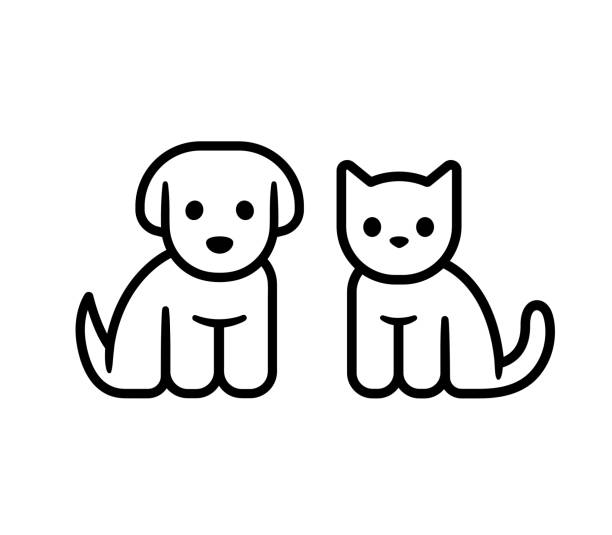

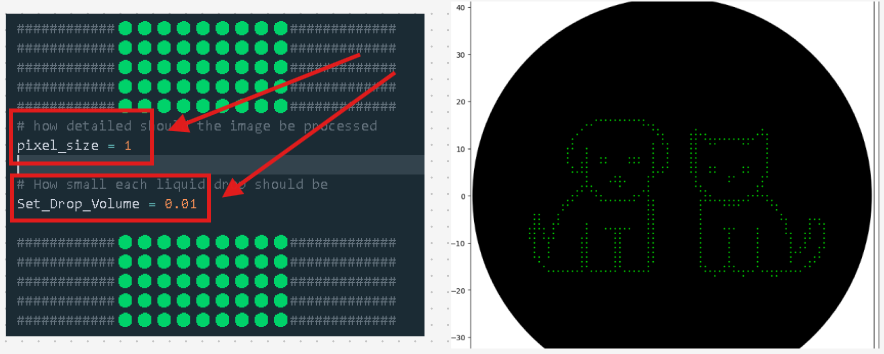

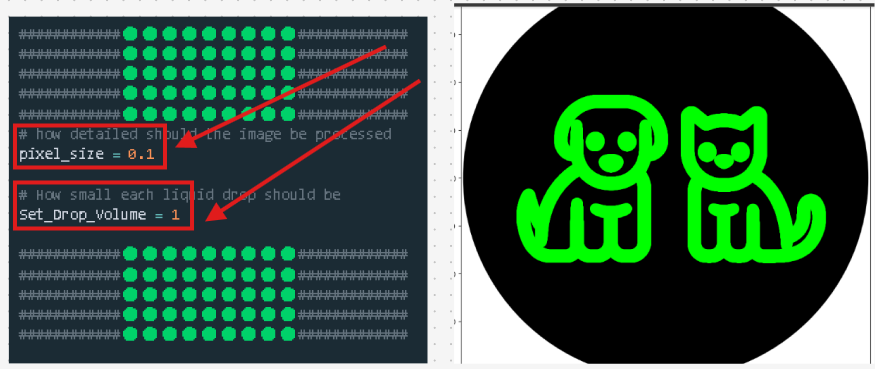

In [ ]:
############🟢🟢🟢🟢🟢🟢🟢🟢🟢#############
############🟢🟢🟢🟢🟢🟢🟢🟢🟢#############
############🟢🟢🟢🟢🟢🟢🟢🟢🟢#############
############🟢🟢🟢🟢🟢🟢🟢🟢🟢#############
############🟢🟢🟢🟢🟢🟢🟢🟢🟢#############
# how detailed should the image be processed
pixel_size = 0.1

# How small each liquid drop should be
Set_Drop_Volume = 0.01

############🟢🟢🟢🟢🟢🟢🟢🟢🟢#############
############🟢🟢🟢🟢🟢🟢🟢🟢🟢#############
############🟢🟢🟢🟢🟢🟢🟢🟢🟢#############
############🟢🟢🟢🟢🟢🟢🟢🟢🟢#############
############🟢🟢🟢🟢🟢🟢🟢🟢🟢#############

In [ ]:






# Import necessary libraries
from google.colab import files
from PIL import Image
import io
import numpy as np
from math import floor

# Function to convert image to coordinates
def image_to_coordinates(img, pixel_size=0.1):
    """
    Convert an image to a list of black pixel coordinates within a circular area.

    Parameters:
    - img: PIL Image object
    - pixel_size: Float, step size for sampling coordinates (default 0.1)

    Returns:
    - List of dictionaries with 'x' and 'y' coordinates
    """
    # Define constants
    canvas_size = 800
    radius = 40
    scale_factor = 10  # Scale factor for logical to canvas coordinates

    # Get original image dimensions
    W, H = img.size

    # Ensure image is in RGB mode
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Calculate scaling to fit within 800x800 canvas
    scale = min(canvas_size / W, canvas_size / H)
    resized_W = int(W * scale)
    resized_H = int(H * scale)

    # Resize the image
    resized_img = img.resize((resized_W, resized_H), Image.LANCZOS)

    # Create a new 800x800 canvas with white background
    canvas_img = Image.new('RGB', (canvas_size, canvas_size), (255, 255, 255))
    x_paste = (canvas_size - resized_W) // 2
    y_paste = (canvas_size - resized_H) // 2
    canvas_img.paste(resized_img, (x_paste, y_paste))

    # Convert canvas to numpy array for efficient pixel access
    canvas_array = np.array(canvas_img)

    # Initialize list to store coordinates
    black_pixels = []

    # Generate grid and extract coordinates
    for y in np.arange(-radius, radius, pixel_size):
        for x in np.arange(-radius, radius, pixel_size):
            # Check if point is within circular area (x^2 + y^2 <= r^2)
            if x**2 + y**2 <= radius**2:
                # Map logical coordinates to canvas coordinates
                canvas_x = floor((x + radius) * scale_factor)
                canvas_y = floor((y + radius) * scale_factor)

                # Ensure coordinates are within canvas bounds
                if 0 <= canvas_x < canvas_size and 0 <= canvas_y < canvas_size:
                    # Get RGB values
                    r, g, b = canvas_array[canvas_y, canvas_x]
                    # Calculate brightness using luminance formula
                    brightness = (0.299 * r + 0.587 * g + 0.114 * b) / 255
                    # Check if pixel is "black"
                    if brightness < 0.5:
                        # Store coordinates with y inverted, rounded to 3 decimals
                        black_pixels.append({
                            'x': round(x, 3),
                            'y': round(-y, 3)
                        })

    return black_pixels

# Upload image in Colab

uploaded = files.upload()

# Get the uploaded image
filename = list(uploaded.keys())[0]
image_data = uploaded[filename]
img = Image.open(io.BytesIO(image_data))

# Process the image and store coordinates in 'data'
data = image_to_coordinates(img, pixel_size)


Saving 4.png to 4.png



=== VOLUME TOTALS BY COLOR ===
	Green:		 aspirated 999.0200000000166	 dispensed 995.3499999992398		##### WASTING BIO-INK : more aspirated than dispensed!
	[all colors]:	[aspirated 999.0200000000166]	[dispensed 995.3499999992398]

=== TIP COUNT ===
	 Used 1 tip(s)  (ideally exactly one per unique color)




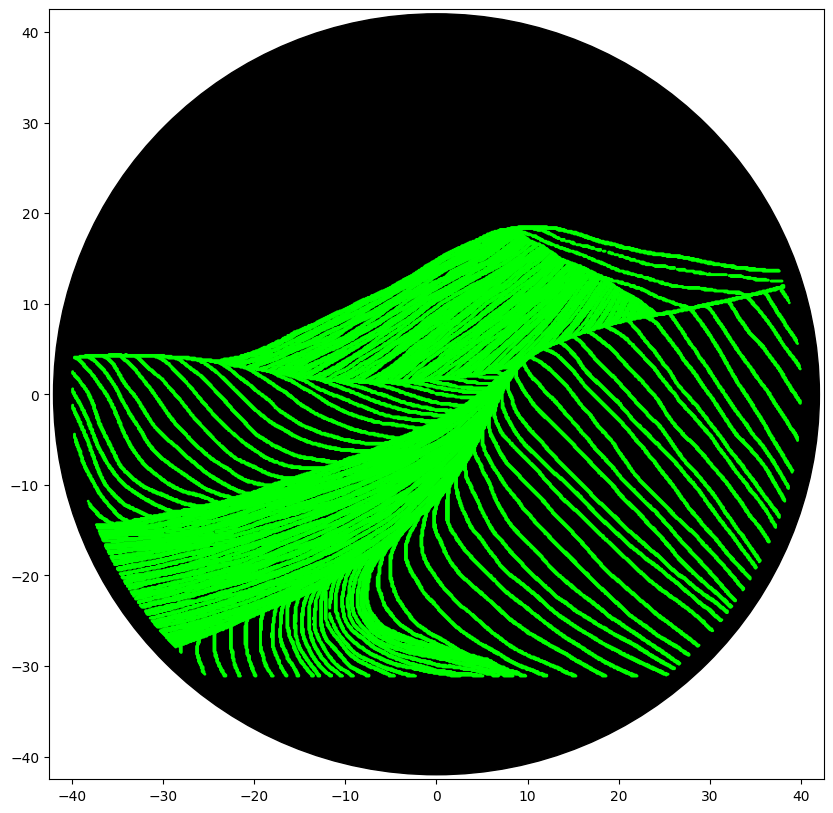

In [ ]:
from opentrons import types

metadata = {
    'protocolName': 'HTGAA Opentrons Lab',
    'author': 'HTGAA Alireza Hekmati'     ,
    'source': 'HTGAA 2025',
    'apiLevel': '2.20'
}

##############################################################################
###   Robot deck setup constants - don't change these
##############################################################################

TIP_RACK_DECK_SLOT = 9
COLORS_DECK_SLOT = 6
AGAR_DECK_SLOT = 5
PIPETTE_STARTING_TIP_WELL = 'A1'

well_colors = {
    'A1' : 'Red',
    'B1' : 'Yellow',
    'C1' : 'Green',
    'D1' : 'Cyan',
    'E1' : 'Blue'       # if in a 24-well plate, this needs to be moved to e.g. D2
}


def run(protocol):
  ##############################################################################
  ###   Load labware, modules and pipettes
  ##############################################################################

  # Tips
  tips_20ul = protocol.load_labware('opentrons_96_tiprack_20ul', TIP_RACK_DECK_SLOT, 'Opentrons 20uL Tips')

  # Pipettes
  pipette_20ul = protocol.load_instrument("p20_single_gen2", "right", [tips_20ul])

  # Modules
  temperature_module = protocol.load_module('temperature module gen2', COLORS_DECK_SLOT)

  # Temperature Module Plate
  temperature_plate = temperature_module.load_labware('opentrons_96_aluminumblock_generic_pcr_strip_200ul',
                                                      'Cold Plate')
  # Choose where to take the colors from
  color_plate = temperature_plate

  # Agar Plate
  agar_plate = protocol.load_labware('htgaa_agar_plate', AGAR_DECK_SLOT, 'Agar Plate')  ## TA MUST CALIBRATE EACH PLATE!
  # Get the top-center of the plate, make sure the plate was calibrated before running this
  center_location = agar_plate['A1'].top()

  pipette_20ul.starting_tip = tips_20ul.well(PIPETTE_STARTING_TIP_WELL)

  ##############################################################################
  ###   Patterning
  ##############################################################################

  ###
  ### Helper functions for this lab
  ###

  # pass this e.g. 'Red' and get back a Location which can be passed to aspirate()
  def location_of_color(color_string):
    for well,color in well_colors.items():
      if color.lower() == color_string.lower():
        return color_plate[well]
    raise ValueError(f"No well found with color {color_string}")

  # For this lab, instead of calling pipette.dispense(1, loc) use this: dispense_and_jog(pipette, 1, loc)
  def dispense_and_jog(pipette, volume, location):
      """
      Dispense and then move up 5mm and back down to shake all dispensed fluid off the tip;
      this also ensures it's not moving laterally before the dispense is done.
      """
      assert(isinstance(volume, (int, float)))
      pipette.dispense(volume, location)
      currLoc = pipette._get_last_location_by_api_version()
      pipette.move_to(currLoc.move(types.Point(z=5)))
      pipette.move_to(currLoc)

  ###
  ### YOUR CODE HERE to create your design
  ###

  # In this example, we will create an array of dots, and streak the last dot using move_to
  Set_Max_Volume = 20
  # Aspirate
  pipette_20ul.pick_up_tip()
  pipette_20ul.aspirate(Set_Max_Volume, location_of_color('Green'))

  # Pattern a 1uL dot array

  max_volume = Set_Max_Volume
    # uncoment for image to art converter
  for point in data:
        # Check if we have at least twice of drop available;
        # if not, replenish (aspirate) first.
        if max_volume < Set_Drop_Volume * 2:
            pipette_20ul.aspirate(Set_Max_Volume - max_volume, location_of_color('Green'))
            max_volume = Set_Max_Volume  # update max_volume after aspirating

        # Dispense at the adjusted location
        x, y = point["x"], point["y"]
        adjusted_location = center_location.move(types.Point(x, y))
        dispense_and_jog(pipette_20ul, Set_Drop_Volume, adjusted_location)

        # Deduct the dispensed volume from max_volume
        max_volume -= Set_Drop_Volume


  # Clean up!
  pipette_20ul.drop_tip()

# Execute Simulation / Visualization -- don't change this code block
protocol = OpentronsMock(well_colors)
run(protocol)
protocol.visualize()